In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot
import json
import pandas as pd
from sklearn import ensemble, linear_model, metrics
import pickle

import atools
from atools_ml.dataio import df_setup
from atools_ml.prep import dimensionality_reduction

from trainML import train_rf
from predictML import evaluate_model
import json

import matplotlib 
from matplotlib import pyplot as plt

In [2]:
splitted_path = '../../data/splitted-data'
train_datas = {'5050': f'{splitted_path}/mixed5050/nbins-10/set_0',
               'everything': f'{splitted_path}/everything/nbins-10/set_0'}

test_datas = {'5050': f'{splitted_path}/mixed5050/nbins-10/test_set.csv',
              '2575': f'{splitted_path}/mixed2575/nbins-10/test_set.csv',
              'everything': f'{splitted_path}/everything/nbins-10/test_set.csv'}
csv_output = {'5050': f'{splitted_path}/mixed5050/skewed',
          'everything': f'{splitted_path}/everything/skewed'}

model_output = {'5050': f'../models/mixed5050/skewed',
                'everything': f'../models/everything/skewed'}
targets = ['COF', 'intercept']
sections = ['top', 'bot', 'extrema']


In [3]:
splitted_datas = dict()
n = 1000
for train_set in train_datas:
    splitted_datas[f'top_{train_set}'] = dict()
    splitted_datas[f'bot_{train_set}'] = dict()
    splitted_datas[f'extrema_{train_set}'] = dict()
    for target in ['COF', 'intercept']:
        sorted_data = pd.read_csv(f'{train_datas[train_set]}/{target}_all.csv', index_col=0).sort_values(by=target)
        splitted_datas[f'top_{train_set}'][target] = sorted_data.head(n)
        splitted_datas[f'bot_{train_set}'][target] = sorted_data.tail(n)
        splitted_datas[f'extrema_{train_set}'][target] = sorted_data.head(int(n/2)).append(sorted_data.tail(int(n/2)))


In [4]:
for train_set in train_datas:
    for section in sections:
        for target in targets:
            splitted_datas[f'{section}_{train_set}'][target].to_csv(
                f'{csv_output[train_set]}/{section}_{n}_{target}_{train_set}.csv')

In [5]:
for train_set in train_datas:
    for section in sections:
        for target in targets:
            output_path = f'{model_output[train_set]}/{section}_{n}_{target}_{train_set}'
            train_rf(data=splitted_datas[f'{section}_{train_set}'][target],
                     target=target, 
                     output_path=output_path,
                     overwrite=True)
            
            

Model saved out to ../models/mixed5050/skewed/top_1000_COF_5050.pickle
Features saved out to ../models/mixed5050/skewed/top_1000_COF_5050.ptxt
Model saved out to ../models/mixed5050/skewed/top_1000_intercept_5050.pickle
Features saved out to ../models/mixed5050/skewed/top_1000_intercept_5050.ptxt
Model saved out to ../models/mixed5050/skewed/bot_1000_COF_5050.pickle
Features saved out to ../models/mixed5050/skewed/bot_1000_COF_5050.ptxt
Model saved out to ../models/mixed5050/skewed/bot_1000_intercept_5050.pickle
Features saved out to ../models/mixed5050/skewed/bot_1000_intercept_5050.ptxt
Model saved out to ../models/mixed5050/skewed/extrema_1000_COF_5050.pickle
Features saved out to ../models/mixed5050/skewed/extrema_1000_COF_5050.ptxt
Model saved out to ../models/mixed5050/skewed/extrema_1000_intercept_5050.pickle
Features saved out to ../models/mixed5050/skewed/extrema_1000_intercept_5050.ptxt
Model saved out to ../models/everything/skewed/top_1000_COF_everything.pickle
Features sav

In [6]:
test_5050_path = f'../../data/splitted-data/mixed5050/nbins-10/test_set.csv'
test_2575_path = f'../../data/splitted-data/mixed2575/nbins-10/test_set.csv'
test_everything_path = f'../../data/splitted-data/everything/nbins-10/test_set.csv'

mresults_path = f'../predicted-results/mixed5050/skewed'
eresults_path = f'../predicted-results/everything/skewed'

mmodels_path = f'../models/mixed5050/skewed'
emodels_path = f'../models/everything/skewed'

In [7]:
predicted_paths = {'5050': mresults_path,
               'everything': eresults_path}
tsets = {'5050': test_5050_path, 
         '2575': test_2575_path, 
         'everything': test_everything_path}

In [8]:
for tset in tsets:
    for train_set in train_datas:
        for section in sections:
            for target in targets:
                model = f'{model_output[train_set]}/{section}_{n}_{target}_{train_set}'
                predicted = f'{predicted_paths[train_set]}/{section}_{n}_{target}_on_{tset}.json'
                evaluate_model(test_df=tsets[tset],
                               model=model+'.pickle',
                               target=target,
                               features=model+'.ptxt', 
                               descriptors=None,
                               output_path=predicted)

Saving out to ../predicted-results/mixed5050/skewed/top_1000_COF_on_5050.json.
Saving out to ../predicted-results/mixed5050/skewed/top_1000_intercept_on_5050.json.
Saving out to ../predicted-results/mixed5050/skewed/bot_1000_COF_on_5050.json.
Saving out to ../predicted-results/mixed5050/skewed/bot_1000_intercept_on_5050.json.
Saving out to ../predicted-results/mixed5050/skewed/extrema_1000_COF_on_5050.json.
Saving out to ../predicted-results/mixed5050/skewed/extrema_1000_intercept_on_5050.json.
Saving out to ../predicted-results/everything/skewed/top_1000_COF_on_5050.json.
Saving out to ../predicted-results/everything/skewed/top_1000_intercept_on_5050.json.
Saving out to ../predicted-results/everything/skewed/bot_1000_COF_on_5050.json.
Saving out to ../predicted-results/everything/skewed/bot_1000_intercept_on_5050.json.
Saving out to ../predicted-results/everything/skewed/extrema_1000_COF_on_5050.json.
Saving out to ../predicted-results/everything/skewed/extrema_1000_intercept_on_5050.

In [12]:
def plot_double_simulated_predicted(
                COF_data, intercept_data,
                output,
                bound_lines=None,
                alpha=0.1):
    """Plot both COF and intercept models simulated vs predicted on the same plot
    """
    if isinstance(COF_data, str):
        with open(COF_data, 'r') as f:
            COF_data = json.load(f)
    if isinstance(intercept_data, str):
        with open(intercept_data, 'r') as f:
            intercept_data = json.load(f)

    # Parse plot title
    # Can play with this more later
    output_file = os.path.split(output)[1]

    data = {**COF_data,
            **intercept_data}
    results = {'COF' : {
                'x' : list(),
                'y' : list(),
                'r_square' : COF_data['COF'].pop('r_square')},
               'intercept' : {
                'x' : list(),
                'y' : list(),
                'r_square' : intercept_data['intercept'].pop('r_square')}}

    for target in data:
        for idx in data[target]:
            results[target]['x'].append(
                data[target][str(idx)]['predicted-{}'.format(target)])
            results[target]['y'].append(
                data[target][str(idx)]['simulated-{}'.format(target)])


    plt.figure(figsize=(20, 8))
    alpha = alpha

    # Plot COF
    plt.subplot(1, 2, 1)
    plt.title('COF Model', fontsize=28, weight='bold')
    plt.xlabel('COF (Predicted)')
    plt.ylabel('COF (Simulated)')
    plt.scatter(results['COF']['x'], results['COF']['y'], alpha=alpha, marker='o')
    plt.text(x=0.16, y=0.1, s=f'r$^2$={results["COF"]["r_square"]:.3f}', fontsize=28)
    plt.xlim(0.085, 0.2)
    plt.ylim(0.085, 0.2)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False, alpha=0.2)

    if bound_lines:
        yuppers = [x*(1+bound_lines) for x in xpoints]
        ylowers = [x*(1-bound_lines) for x in xpoints]
        plt.plot(xpoints, yuppers, linestyle='--',
            color='k', lw=3, scalex=False,
            scaley=False, alpha=0.2)
        plt.plot(xpoints, ylowers, linestyle='--',
            color='k', lw=3, scalex=False,
            scaley=False, alpha=0.2)

    # Plot intercept
    plt.subplot(1, 2, 2)
    plt.title('F$_{0}$ Model', fontsize=28, weight='bold')
    plt.xlabel('F$_{0}$ (Predicted), nN')
    plt.ylabel('F$_{0}$ (Simulated), nN')
    plt.scatter(results['intercept']['x'], results['intercept']['y'], alpha=alpha, marker='o')
    plt.text(x=5.5, y=0.3, s=f'r$^2$={results["intercept"]["r_square"]:.3f}', fontsize=28)
    plt.xlim(-1, 9)
    plt.ylim(-1, 9)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False, alpha=0.2)

    if bound_lines:
        yuppers = [x*(1+bound_lines) for x in xpoints]
        ylowers = [x*(1-bound_lines) for x in xpoints]
        plt.plot(xpoints, yuppers, linestyle='--',
            color='k', lw=3, scalex=False,
            scaley=False, alpha=0.2)
        plt.plot(xpoints, ylowers, linestyle='--',
            color='k', lw=3, scalex=False,
            scaley=False, alpha=0.2)

    plt.savefig(f'{output}.pdf', dpi=500, bbox_inches='tight')
    
    plt.show()
    plt.close('all')
    return None


5050_top_1000_on_5050


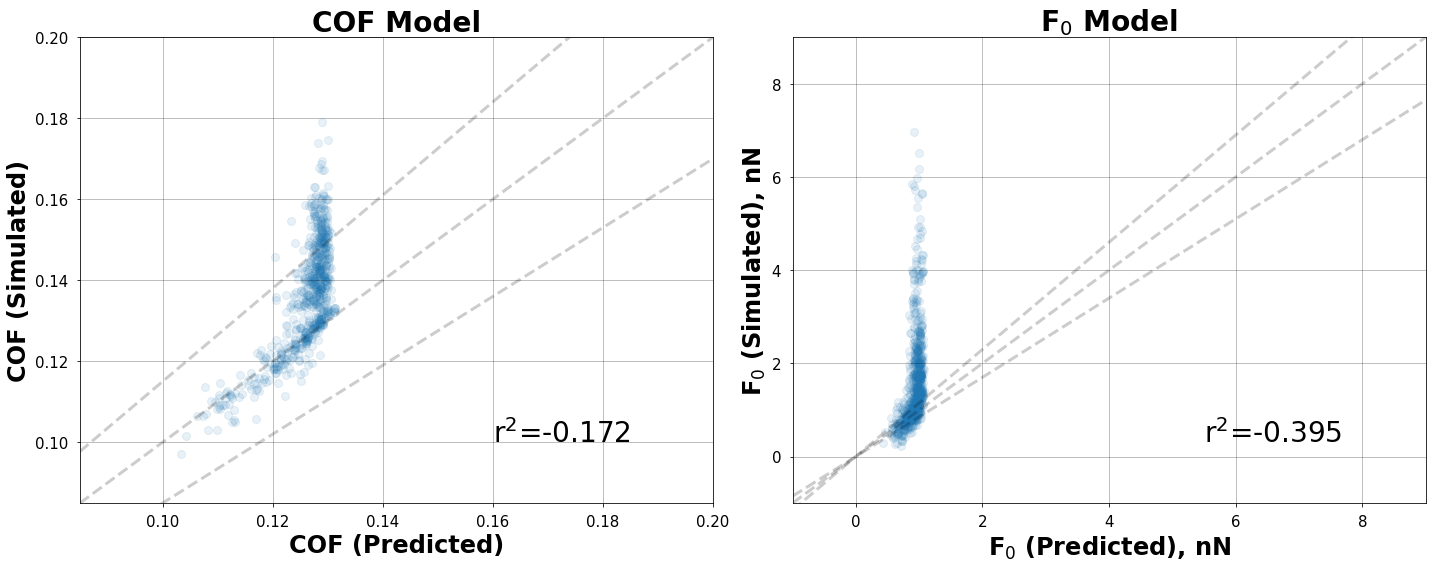

5050_bot_1000_on_5050


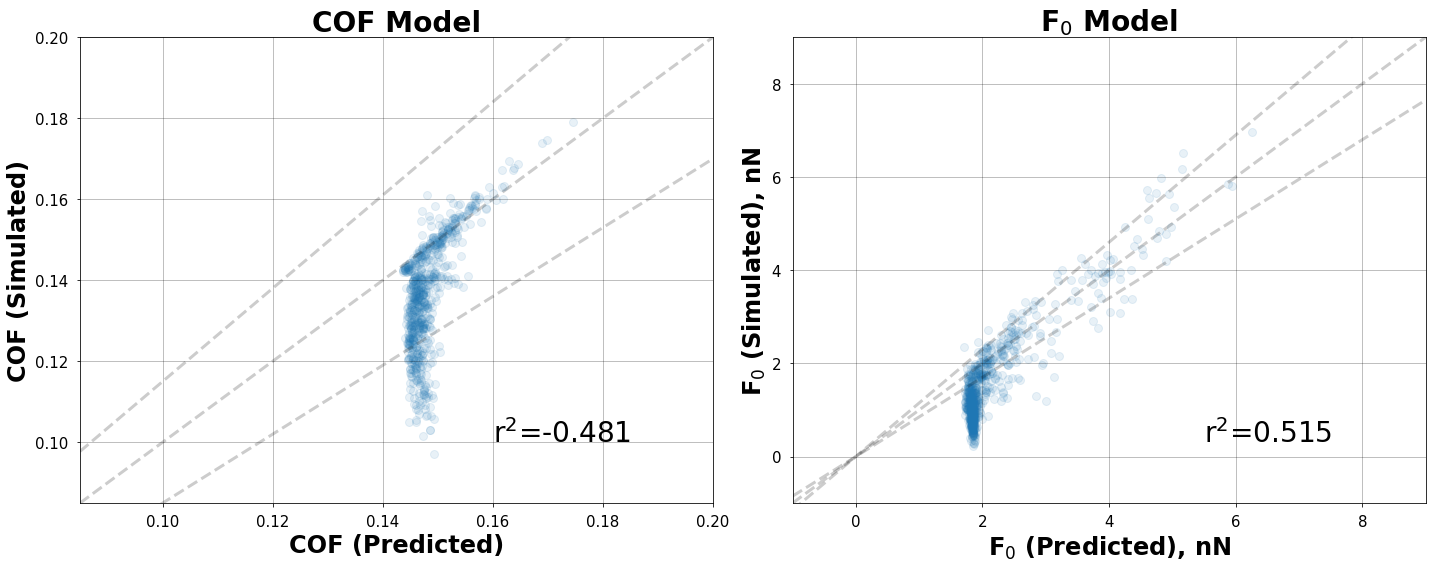

5050_extrema_1000_on_5050


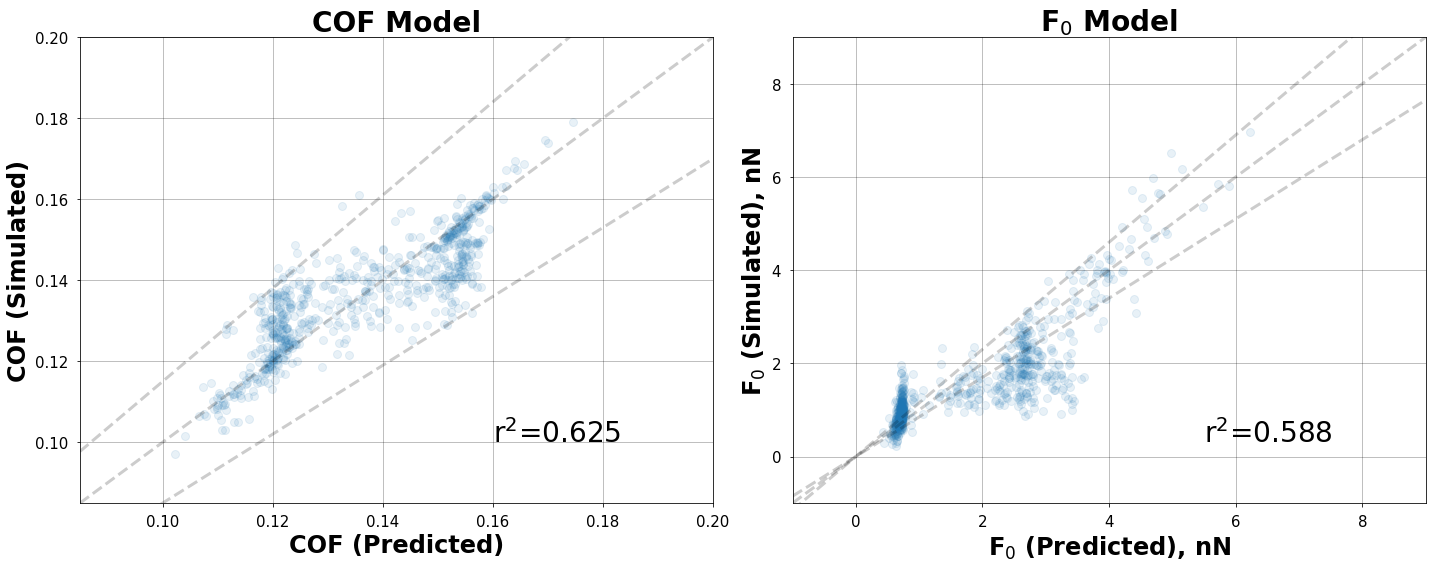

everything_top_1000_on_5050


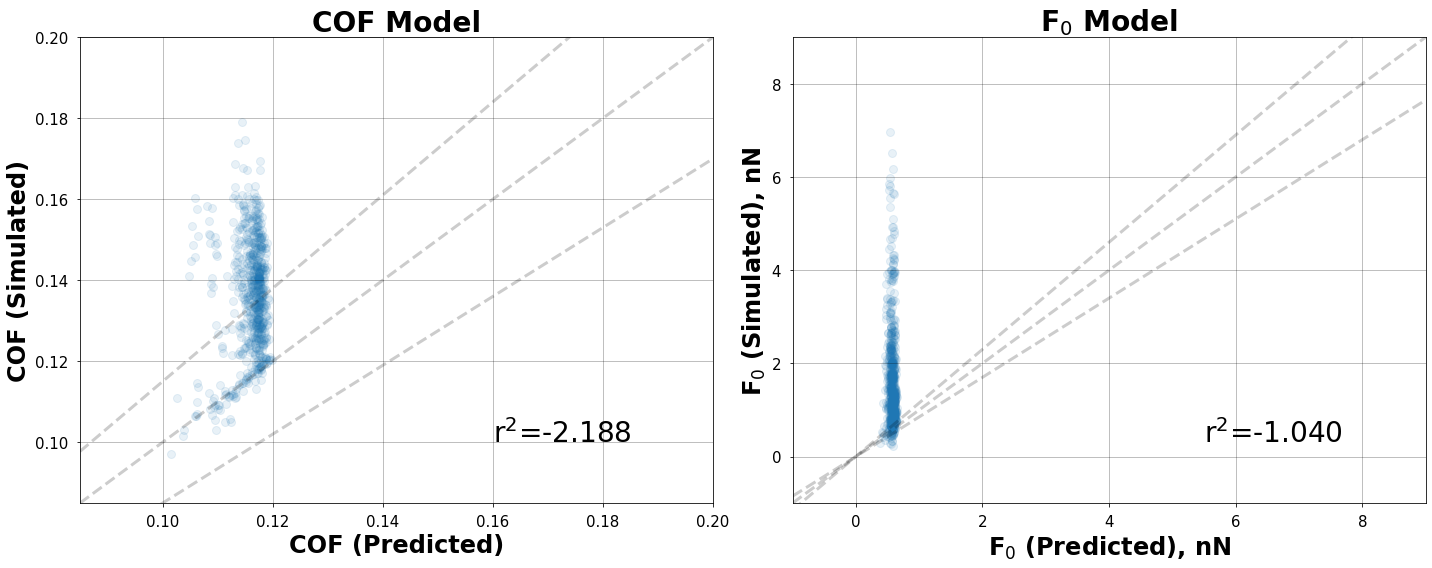

everything_bot_1000_on_5050


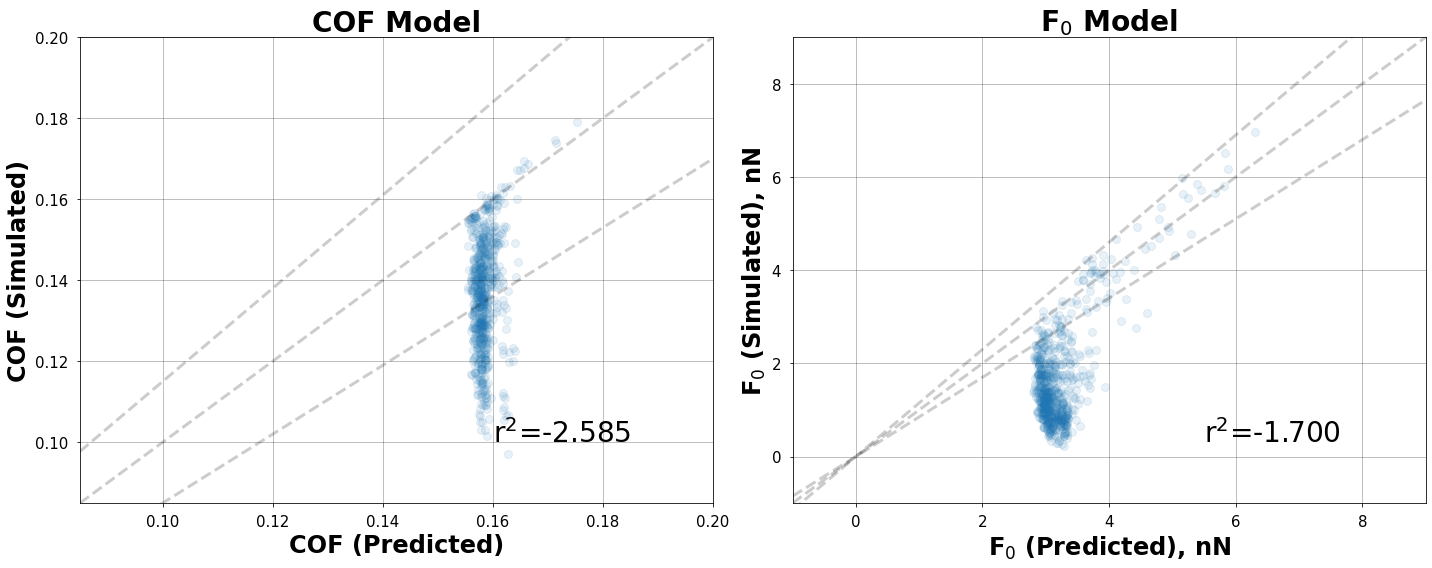

everything_extrema_1000_on_5050


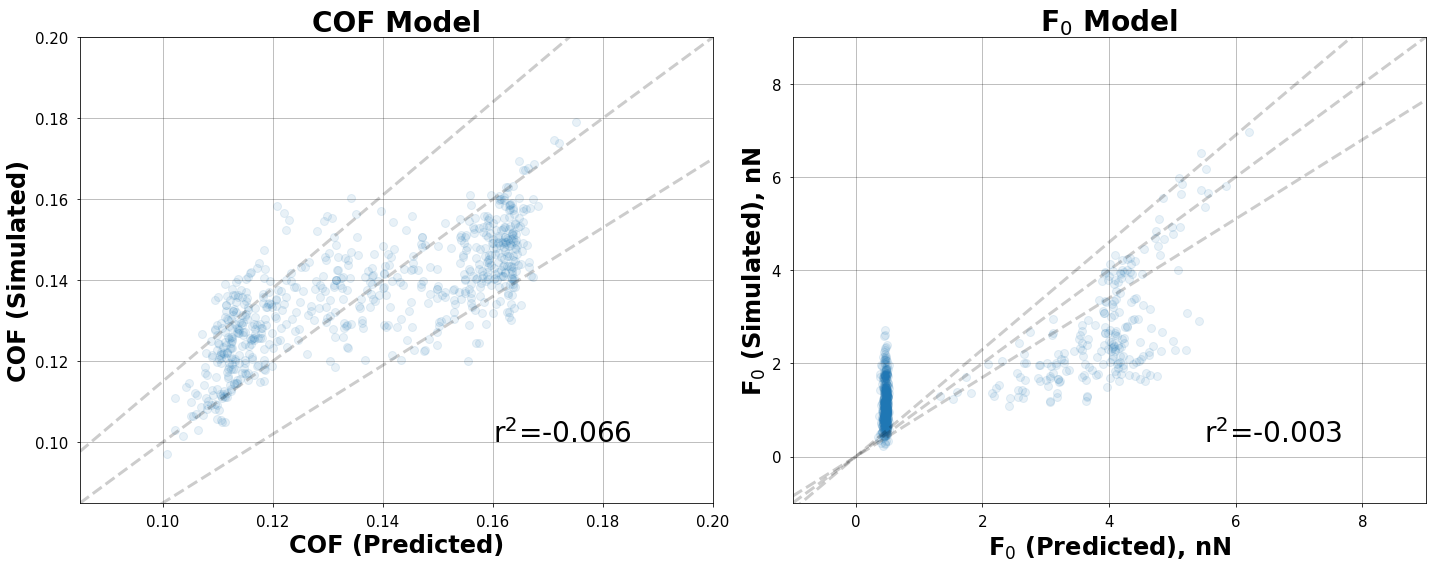

5050_top_1000_on_2575


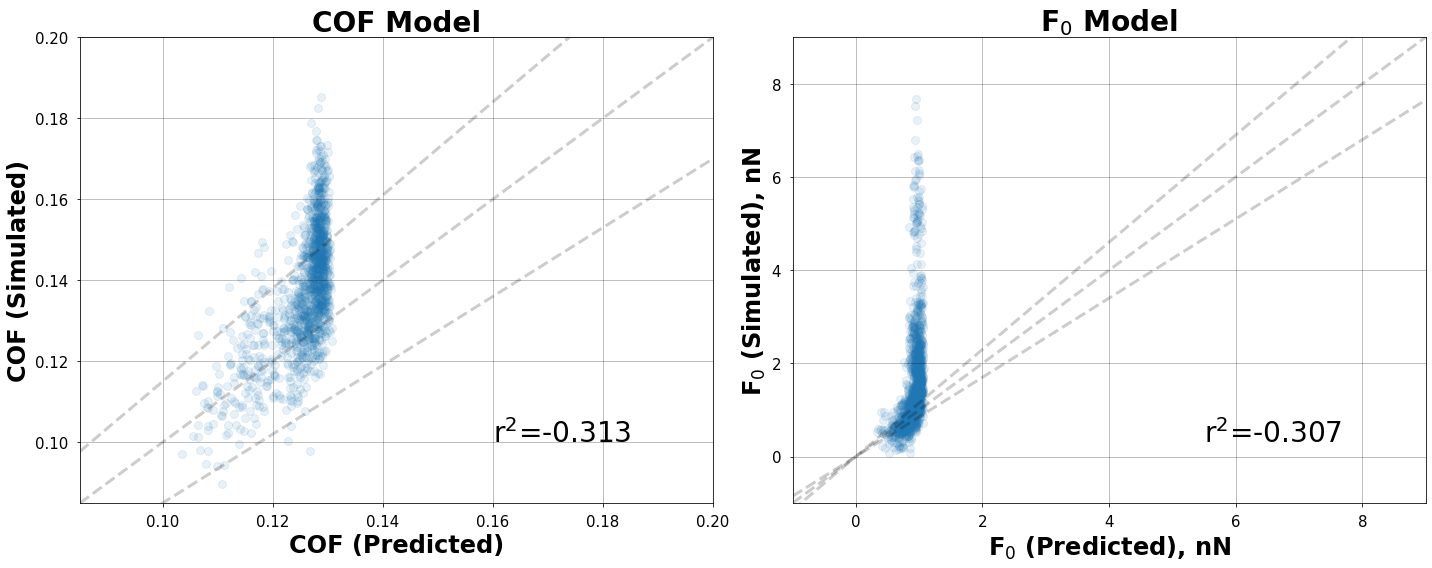

5050_bot_1000_on_2575


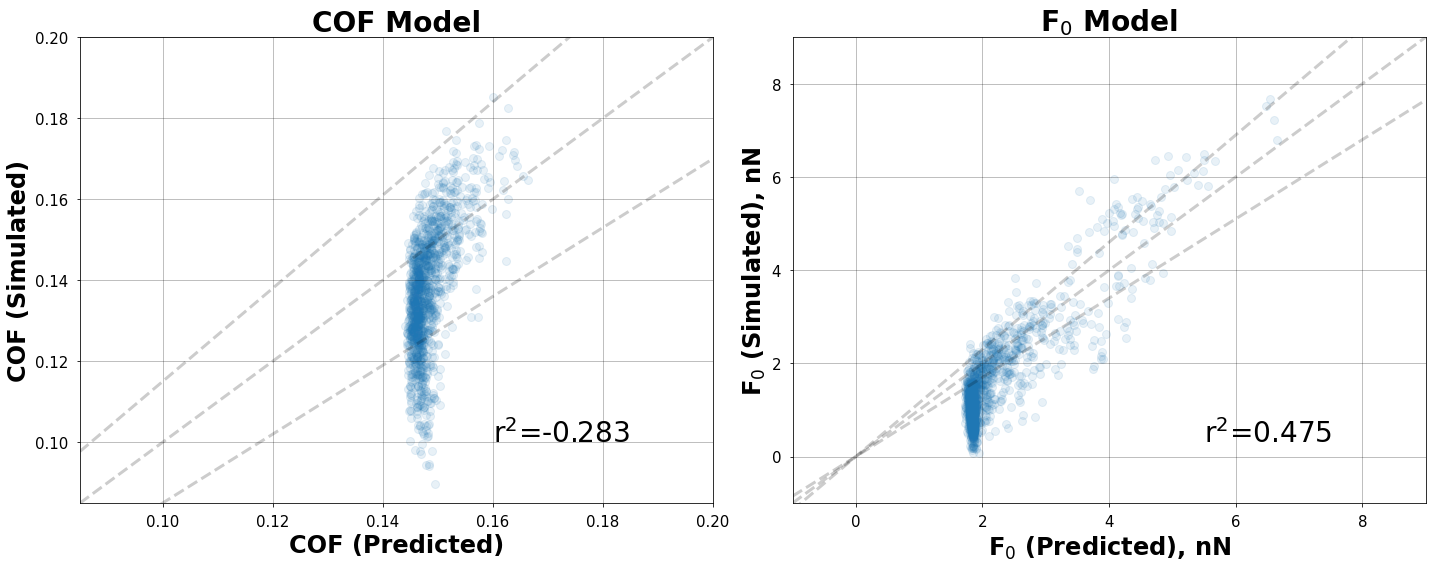

5050_extrema_1000_on_2575


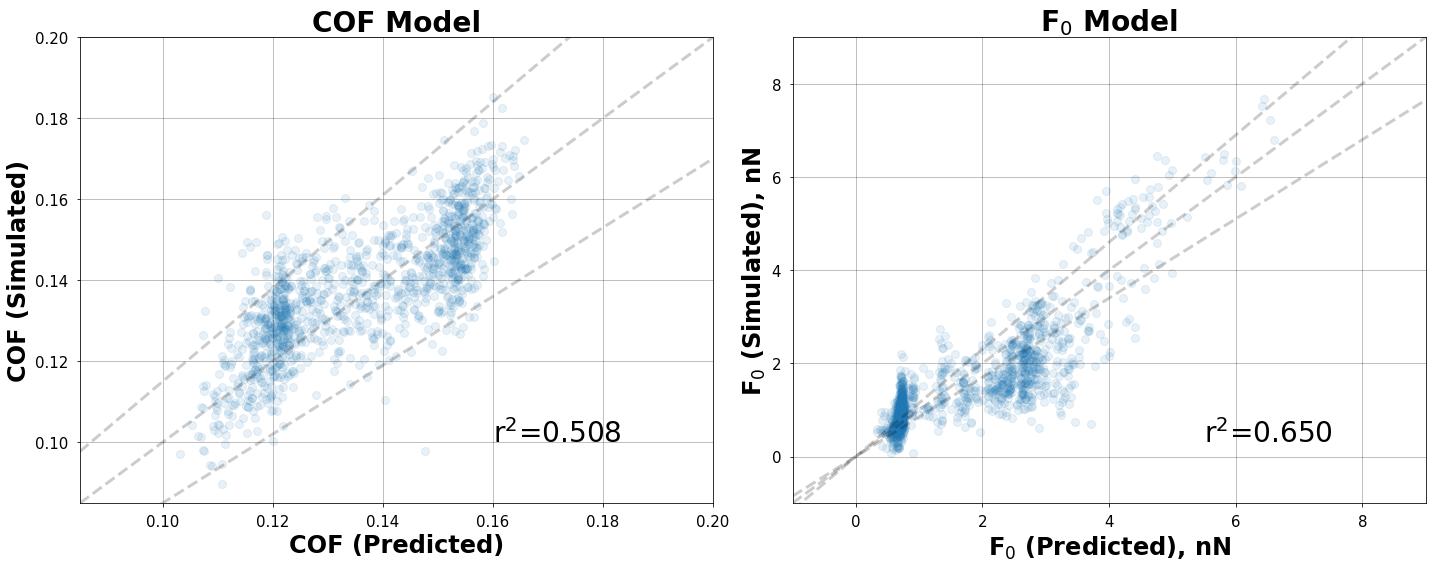

everything_top_1000_on_2575


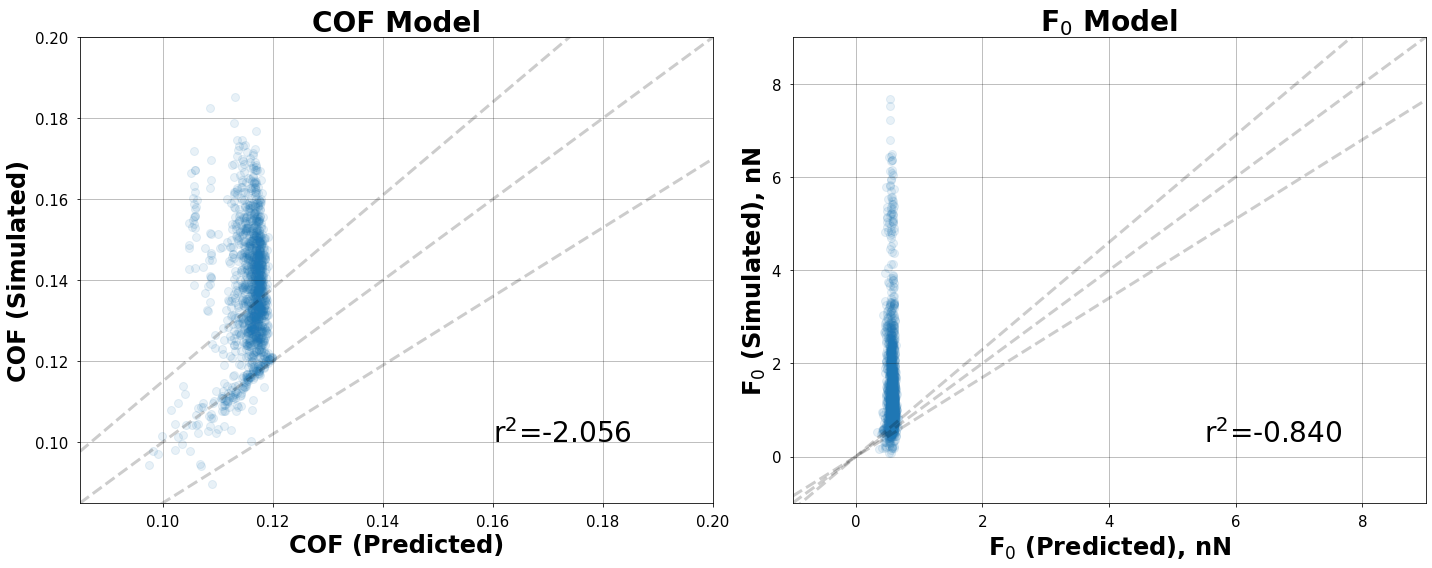

everything_bot_1000_on_2575


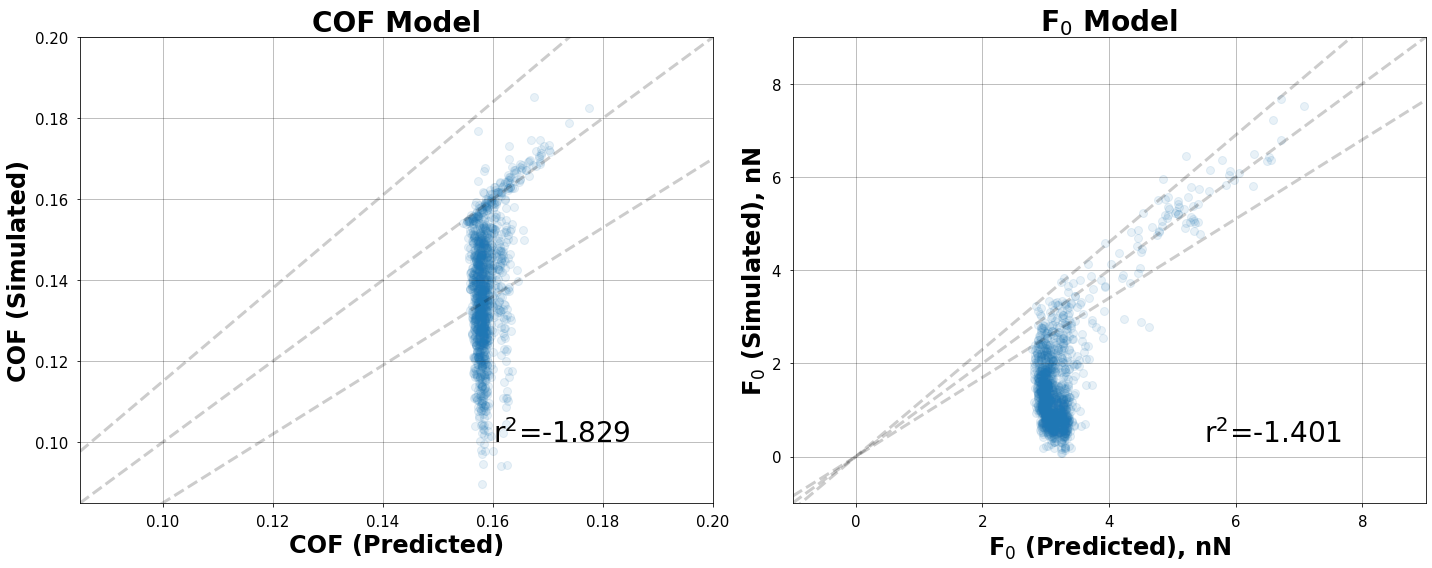

everything_extrema_1000_on_2575


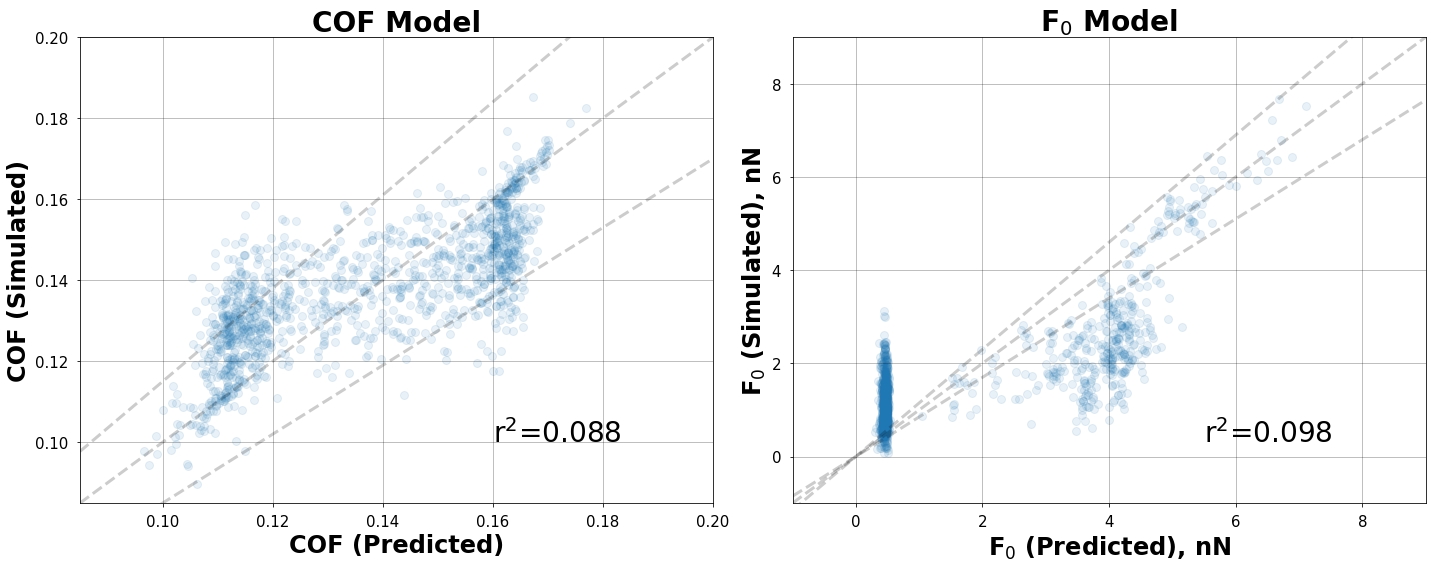

5050_top_1000_on_everything


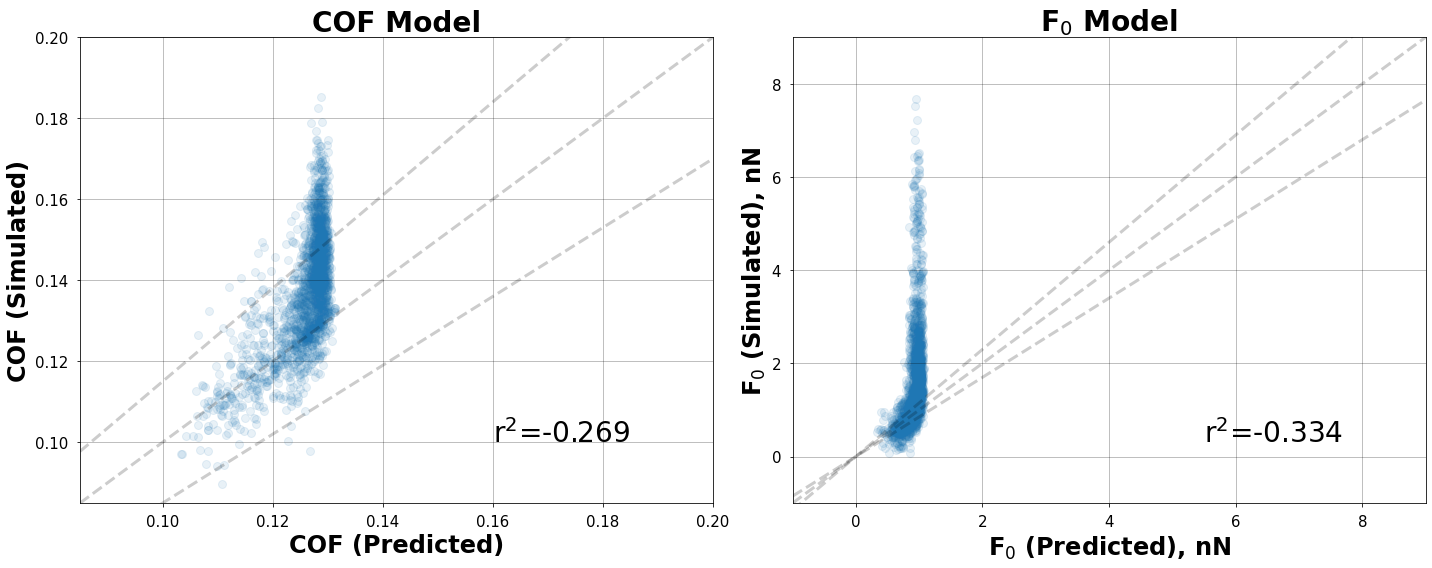

5050_bot_1000_on_everything


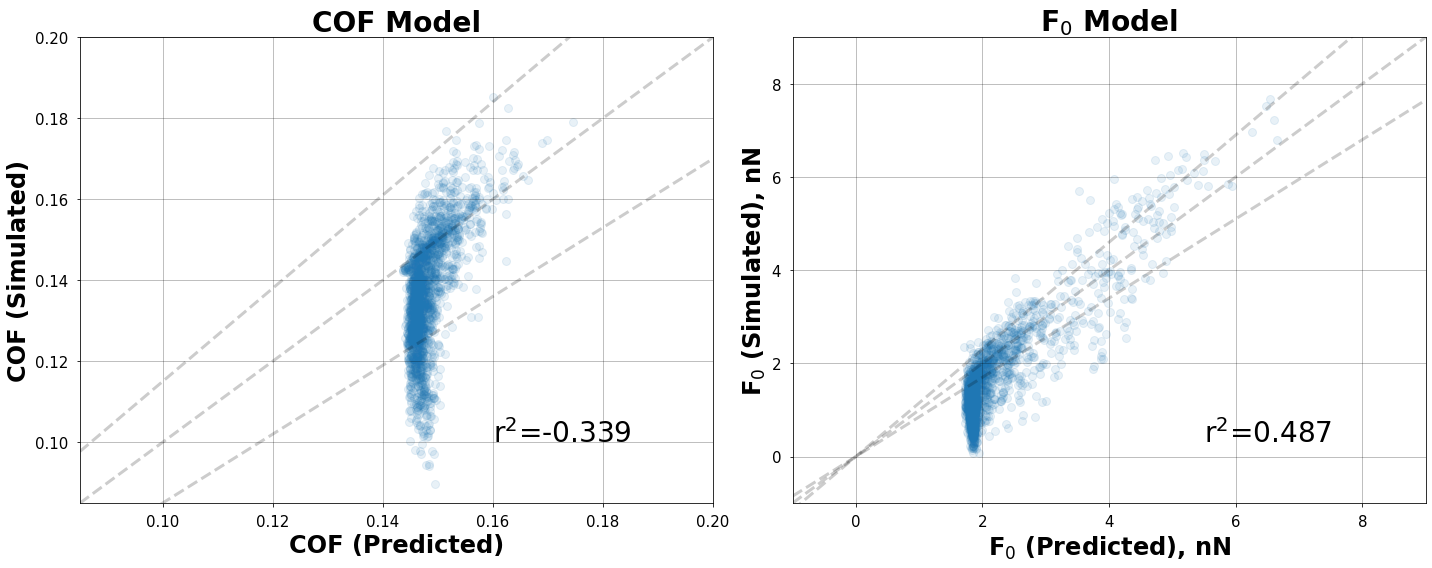

5050_extrema_1000_on_everything


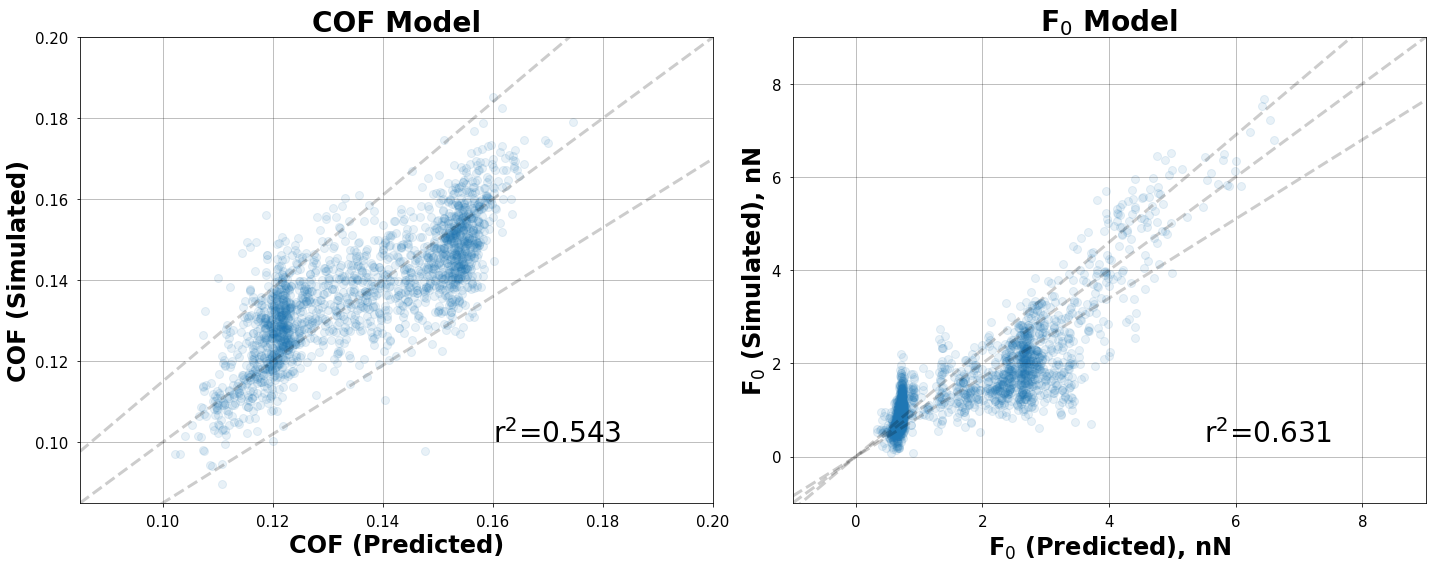

everything_top_1000_on_everything


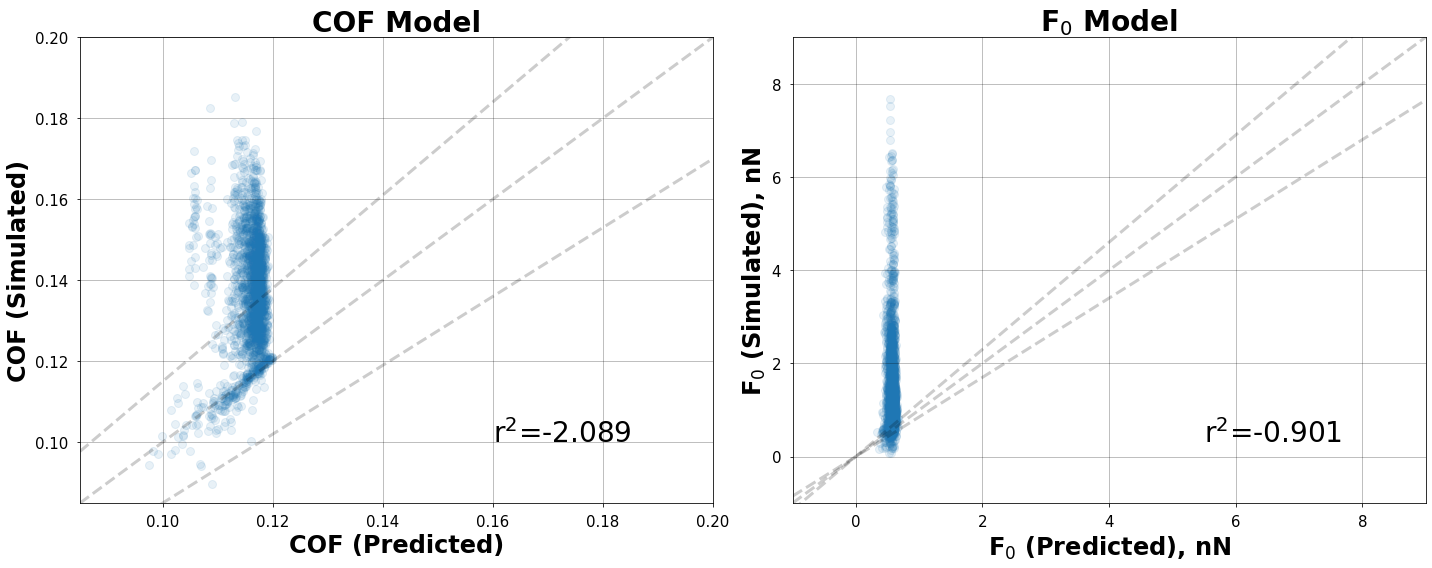

everything_bot_1000_on_everything


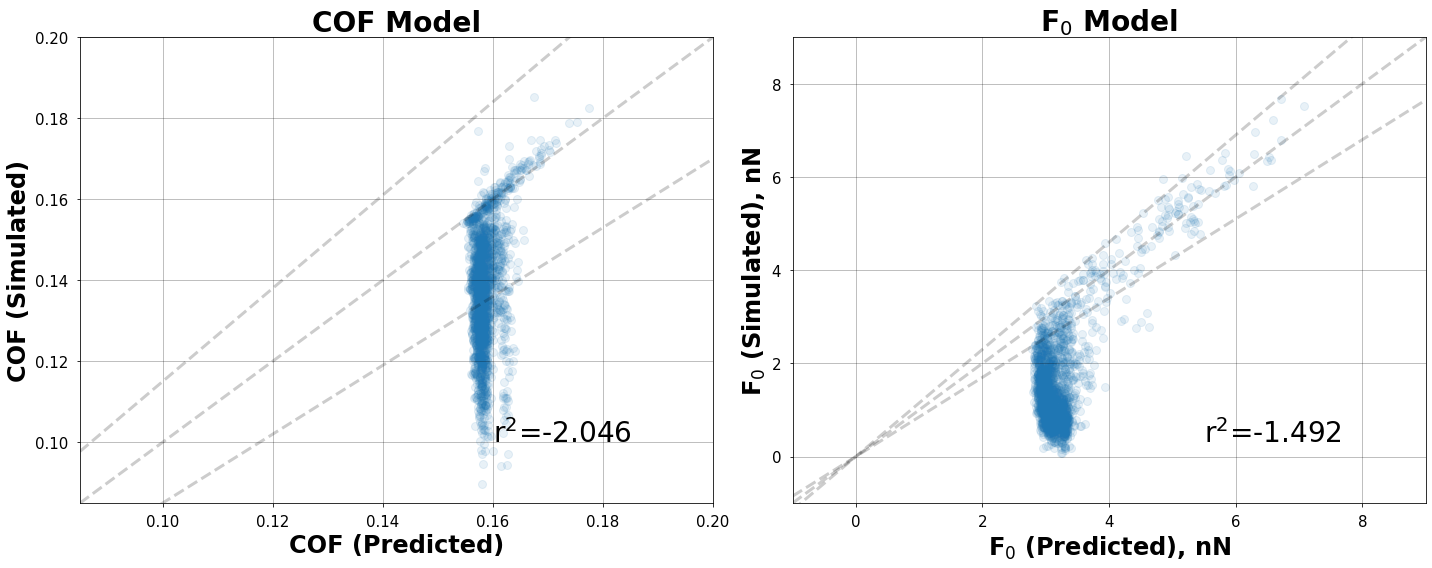

everything_extrema_1000_on_everything


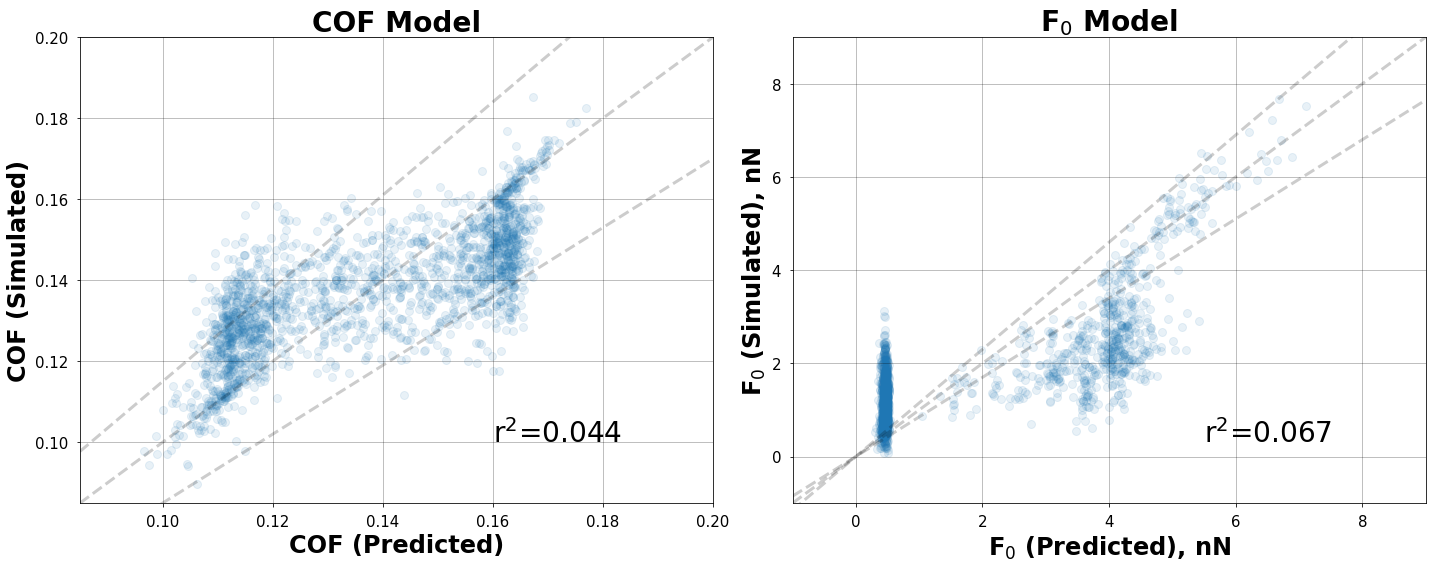

In [13]:
for tset in tsets:
    for train_set in train_datas:
        for section in sections:
            print(f'{train_set}_{section}_{n}_on_{tset}')
            plot_double_simulated_predicted(
                COF_data=f'{predicted_paths[train_set]}/{section}_{n}_COF_on_{tset}.json',
                intercept_data=f'{predicted_paths[train_set]}/{section}_{n}_intercept_on_{tset}.json',
                output=f'plots/skewed/{train_set}_{section}_{n}_on_{tset}.pdf',
                bound_lines=0.15,
                )
            